In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import random
from sklearn.cluster import DBSCAN
import math
from scipy.spatial import distance
from datetime import timedelta
from scipy.stats import chisquare

In [2]:
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import binom
from scipy.stats import poisson

In [3]:
### Data to use
#unpick('keys') - user_id, number pairs
#unpick('user_times_strings') - times of each users tweets (strings)
#unpick('creation dates') - [creation date, first tweet, last tweet] values for each user
#unpick('bin_data_matrix') - binary data matrix
#unpick('data_matrix') - number of tweets by each user for each day spanned by dataset
#unpick('date_vectors') - dictionary of ordered date vectors
#unpick('user_dates') - dictionary of dates users tweeted (datetime obj.)
#unpick('user_datetimes') - dictionary of times users tweeted (datetime obj.)
#debot = unpick('debot_0.99') - bots identified by debot

In [4]:
### Data produced / saved

In [5]:
### Function to save results as .txt files
import pickle
def pick(file, name):
    with open('./ira_txt_1/' + name + '.txt', "wb") as fp:   #Pickling
        pickle.dump(file, fp)
def unpick(name):
    with open('./ira_txt_1/' + name + '.txt', "rb") as fp:   # Unpickling
        file = pickle.load(fp)
    return file

In [6]:
def date_axis(start, xn, p):
    times = pd.date_range(start, periods=xn, freq=p)
    return times
s_date = '2009-05-09'
e_date = '2018-06-21'

In [7]:
### Turns date object to number and number to dateobject
def date_num(date):
    return (date - first_tweet).days
def num_date(num):
    return(first_tweet + timedelta(days = num))

In [44]:
num_date(2424)

datetime.date(2015, 12, 28)

In [8]:
total_users = 3667
total_tweets = 9041308
total_days = 3331
total_weeks = int(math.ceil(total_days/7))

first_tweet = datetime(2009,5,9).date()
last_tweet = datetime(2018,6,21).date()

In [9]:
### Numerical analysis of temporal data

In [10]:
bdm = unpick('bin_data_matrix')
dm = unpick('data_matrix')
cdm = unpick('creation dates') # [creation date, first tweet, last tweet]

In [11]:
users = range(3667)
cds = cdm[users,0]
fds = cdm[users,1]
lds = cdm[users,2]

In [12]:
for i in range(3667):
    if fds[i] > 3140: print('fuck', i)
    if lds[i] < 1775: print('fuck', i) 

fuck 1277
fuck 1316
fuck 1563
fuck 2625
fuck 3097
fuck 3335
fuck 3404
fuck 3486


In [13]:
all_users = range(3667)
wk_ax = np.array(range(total_weeks)) * 7

In [14]:
def volume(users):
    data = dm[users]
    return np.sum(data,0)

def active(users):
    data = bdm[users]
    return np.sum(data,0)

def week_volume(volume):
    data = np.zeros(total_weeks,int)
    for i in range(total_weeks):
        data[i] = np.sum( volume[ i * 7 : (i + 1) * 7] )
    return data

def active_week(users):
    data = np.zeros((total_weeks),int)
    for i in range(total_weeks):
        temp = np.sum(bdm[users, i * 7 : (i + 1) * 7],1)
        temp[temp>0] = 1
        data[i] = np.sum(temp)
    return data

def created_active(users):
    cds = cdm[users,0]
    fds = cdm[users,1]
    lds = cdm[users,2]
    cr = np.zeros(3331)
    ac = np.zeros(3331)
    for i in range(len(users)):
        c = cds[i]
        f = fds[i]
        l = lds[i]
        cr[c:l+1] += 1
        ac[f:l+1] += 1
    return cr,ac

In [15]:
def get_pcnt(users, fd,ld):
    cr, ac = created_active(users)
    posted = active(users)
    ac = ac[fd:ld]
    posted = posted[fd:ld]
    return posted / ac

def get_dist(users, fd, ld):
    pcnt = get_pcnt(users,fd,ld)
    obs = np.copy(pcnt)
    pcnt = pcnt*100
    pcnt = list(map(int, list(pcnt)))
    freq = np.zeros(101,int)
    for i in range(101):
        freq[i] = pcnt.count(i)
    return (freq / len(pcnt)), obs

In [16]:
def est_gmm(data, comps):
    gmm = GMM(comps)
    gmm.fit(data.reshape(-1,1))
    t = np.linspace(0,1,101)
    y = gmm.score_samples(t.reshape(-1, 1))
    return gmm, np.exp(y) / 100

def model(gmm):
    w1, w2 = gmm.weights_
    m1, m2 = gmm.means_
    x = range(101)
    print('w1,w2,m1,m2',w1,w2,m1*100,m2*100)
    y = ( w1 * binom.pmf(x, 100, m1) + w2 * binom.pmf(x, 100, m2))
    return y

def single(gmm):
    w1, w2 = gmm.weights_
    m1, m2 = gmm.means_
    mu = w1 * m1 + w2 * m2
    
    if m1 < m2: mu = m2
    else: mu = m1
    
    x = range(101)
    y = binom.pmf(x, 100, mu)
    return y

In [17]:
def present_vol(group, fd, ld):
    
    a_all = active(group)
    a_week = active_week(group)
    cr, ac = created_active(group)

    plt.plot(a_all)
    plt.plot(cr)
    plt.plot(ac)
    plt.plot(wk_ax,a_week)
    plt.xlim(fd,ld)
    plt.show()

    v_all = volume(all_users)
    vw_all = week_volume(v_all)
    plt.plot(v_all)
    plt.plot(wk_ax, vw_all / 7)
    plt.xlim(fd,ld)
    plt.show()

In [18]:
def present_dist(group, fd, ld, peaks = 2, fit = True, double = True, sin = True):
    dist, data = get_dist(group, fd,ld)
    plt.plot(dist)
    peak2 = 0
    if fit == True:
        gmm, best_fit = est_gmm(data, peaks)
        print('W,M,C',gmm.weights_,gmm.means_,gmm.covariances_ * 100**2)
        plt.plot(best_fit)
    if double == True:
        peak2 = model(gmm)
        plt.axvline(39.25, c = 'r', linestyle = ':')
        plt.plot(peak2)
    if sin == True:
        peak = single(gmm)
        plt.plot(peak)
        peak2 = peak
    plt.show()
    return dist, data, peak2

W,M,C [0.43909472 0.56090528] [[0.23005966]
 [0.4124786 ]] [[[51.58360579]]

 [[54.2659807 ]]]
w1,w2,m1,m2 0.43909471578133824 0.5609052842186613 [23.00596604] [41.24785952]


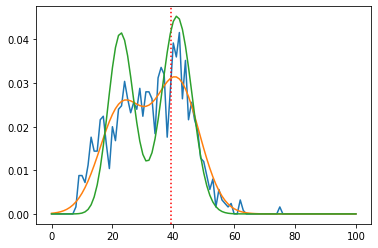

Power_divergenceResult(statistic=979078940.4125719, pvalue=0.0)
W,M,C [0.56090528 0.43909472] [[0.4124786 ]
 [0.23005966]] [[[54.2659807 ]]

 [[51.58360579]]]


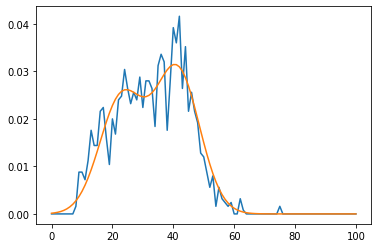

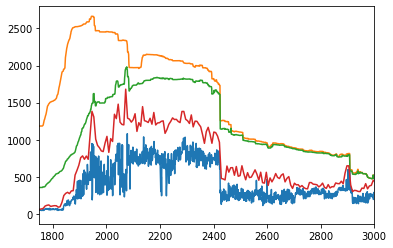

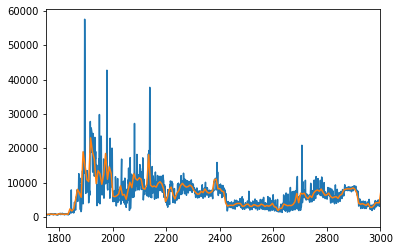

In [19]:
dist, data, peak2 = present_dist(all_users, 1750,3000, 2, True, True, False)
P = chisquare(dist * 1250, peak2 * 1250)
print(P)
present_dist(all_users, 1750,3000, 2, True, False, False)
present_vol(all_users,1750,3000)

In [20]:
### Debot
debot = unpick('debot_0.99')
not_debot = list ( set(range(3667)) - set(debot) )

In [21]:
print(len(debot))
print(len(not_debot))

979
2688


W,M,C [0.64928527 0.35071473] [[0.18485069]
 [0.4810021 ]] [[[ 75.33007114]]

 [[182.85642401]]]


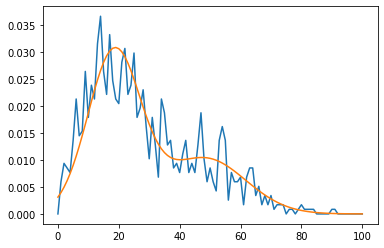

W,M,C [0.46079601 0.53920399] [[0.52044644]
 [0.26529844]] [[[26.45484324]]

 [[24.65378542]]]
w1,w2,m1,m2 0.46079600889622246 0.5392039911037774 [52.04464389] [26.52984423]


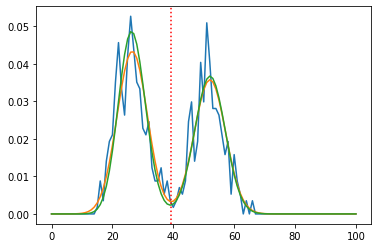

In [22]:
dist, data, peak2 = present_dist(debot, 1855,3030, 2, True, False, False)
dist, data, peak2 = present_dist(not_debot, 2150,2720, 2, True, True, False)

In [23]:
chisquare(dist * 570, peak2 * 570)

Power_divergenceResult(statistic=88.05811871296089, pvalue=0.7975600899253068)

In [24]:
(1 - (0.56**112 * 0.44**88)) ** 6721611

1.0

In [25]:
(1-(0.5**30)) ** (6721611 * 1000) * 100

0.19112686074897225

In [26]:
#dist, data, peak2 = present_dist(loc[0], 1855,3030, 2, True, False, False)

NameError: name 'loc' is not defined

In [ ]:
x = 0
for i in range(len(loc)):
    x += len(loc[i])
print(x)

In [27]:
### Banned users

lds = cdm[all_users,2]
lds = list(lds)
BAN_DAY = max(set(lds), key=lds.count)

print(BAN_DAY)

banned = []
for i in range(len(lds)):
    if lds[i] == BAN_DAY: banned.append(i)
        
print(len(banned))

not_banned = list( set(all_users) - set(banned) )

2424
473


In [28]:
import random
import pandas as pd
#import csv
from datetime import datetime
import matplotlib.pyplot as plt
#import matplotlib
import numpy as np
import sklearn
#import scipy
#import random
from sklearn.cluster import DBSCAN
import math
from scipy.spatial import distance
from datetime import timedelta

In [29]:
def date_axis(start, xn, p):
    times = pd.date_range(start, periods=xn, freq=p)
    return times

days = 3331
weeks = int(math.ceil(days/7))
day_x = date_axis('2009-05-09', days, 'D')
week_x = date_axis('2009-05-09', weeks, 'W')
s_date = '2009-05-09'
e_date = '2018-06-21'

In [30]:
print(len(not_debot) - len(loc[0]))

NameError: name 'loc' is not defined

C:\Users\macki\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]]
(0.8376623376623371, 11, 44)


C:\Users\macki\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\macki\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


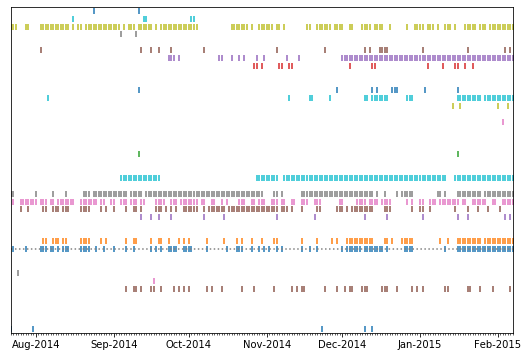

[[0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
(0.7309743941024177, 1, 25)


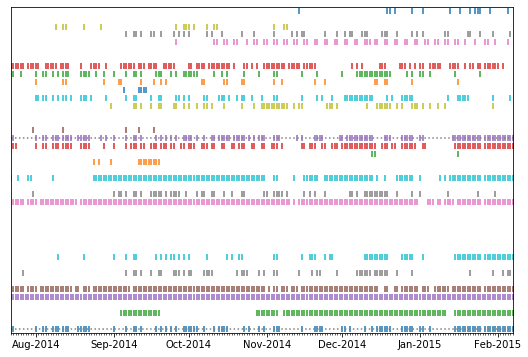

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0.6118592821697247, 7, 8)


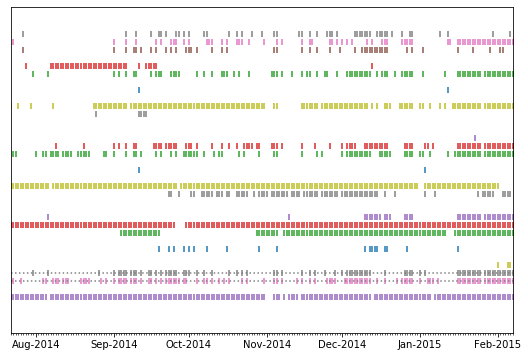

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(0.9234308826288279, 2, 4)


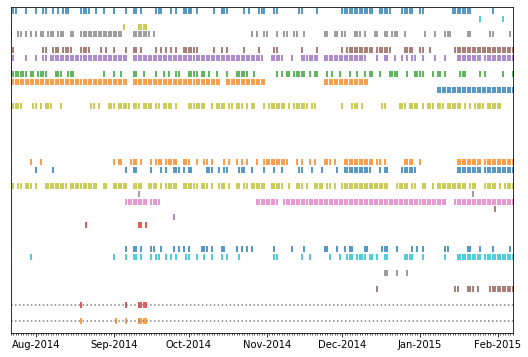

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 22, 40)


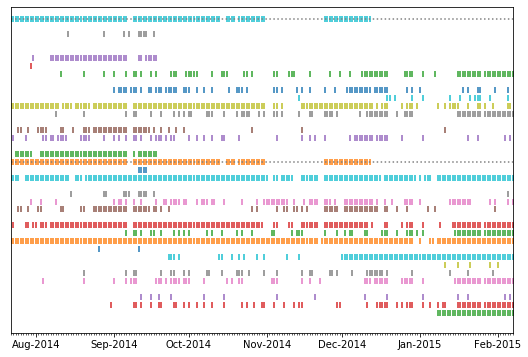

In [31]:
for R in range(5):
    nd = not_debot.copy()
    random.seed(R)
    random.shuffle(nd)

    k = 0

    f, ax = plt.subplots(1,1)
    #if h > 30: h = 10
    f.set_figheight(6)
    f.set_figwidth(9)
    
    fd = 1900
    ld = 2100
    DATA = []
    
    for i in nd:
        k += 1
        x = bdm[i]
#        if k == 22:print(i)
#        if k == 40:print(i)
        ax.scatter(day_x,x * k, marker = '|')
        DATA.append(x[fd:ld])
        if k == 50: break
    
    MAX = (0,0,0)
    DATA = np.array(DATA)
    print(DATA)
    DATA = np.corrcoef(DATA)
    x,y = DATA.shape
    for i in range(x):
        for j in range(y):
            if i < j:
                V = DATA[i,j]
                if V > MAX[0]: MAX = V,i+1,j+1
    print(MAX)
    
    #plt.autofmt_xdate()
    ax.set_xlim(num_date(fd),num_date(ld))
    ax.get_yaxis().set_visible(False)
    ax.axhline(MAX[1], c = 'gray', linestyle = ':')
    ax.axhline(MAX[2], c = 'gray', linestyle = ':')    
    #ax.axvline(num_date(2090 - 1), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 3), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 31), c = 'b', linestyle = ':')
    #ax.axvline(num_date(2090 - 33), c = 'b', linestyle = ':')

    from datetime import datetime
    import matplotlib.dates as mdates

    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months_fmt = mdates.DateFormatter('%b-%Y')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)

    plt.ylim(0.5,k+0.5 - 9)
    plt.show()

116


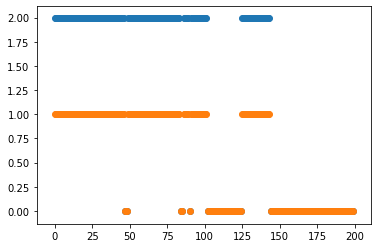

In [32]:
plt.scatter(range(ld-fd),bdm[2567][fd:ld]*2)
plt.scatter(range(ld-fd),bdm[2628][fd:ld])
print(np.sum(bdm[2628][fd:ld]))

In [50]:
h = np.sum(bdm[banned,2100:2424])

In [49]:
j = len(banned)*324

In [51]:
print(h/j)

0.9232505937932295


(0.5, 473.5)

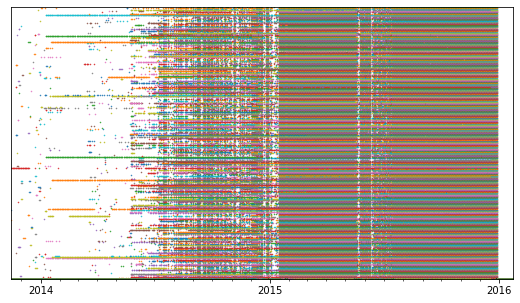

In [45]:
random.seed(42)
random.shuffle(banned)
k = 0

f, ax = plt.subplots(1,1)
#if h > 30: h = 10
f.set_figheight(5)
f.set_figwidth(9)

for i in banned:
    k += 1
    x = bdm[i]
    ax.scatter(day_x,x * k, marker = '.', s = 1)
#    if k == 15: break
        
#plt.autofmt_xdate()
ax.set_xlim(num_date(1650),num_date(2450))
ax.get_yaxis().set_visible(False)


#ax.axvline(num_date(2090 - 1), c = 'r', linestyle = ':')
#ax.axvline(num_date(2090 - 3), c = 'r', linestyle = ':')
#ax.axvline(num_date(2090 - 31), c = 'b', linestyle = ':')
#ax.axvline(num_date(2090 - 33), c = 'b', linestyle = ':')

from datetime import datetime
import matplotlib.dates as mdates

months = mdates.MonthLocator()
days = mdates.DayLocator()
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%b-%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.ylim(0.5,k+0.5)

W,M,C [0.49099923 0.50900077] [[0.97992977]
 [0.47763709]] [[[2.67849328e-01]]

 [[6.34014652e+02]]]


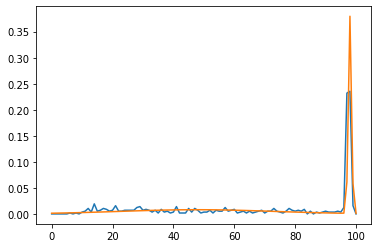

W,M,C [0.65348479 0.34651521] [[0.25128623]
 [0.3727136 ]] [[[ 39.9313555]]

 [[113.1455298]]]


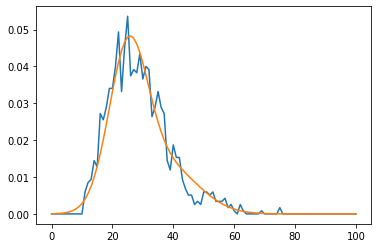

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00595745, 0.00851064, 0.0093617 , 0.01446809,
        0.01276596, 0.02723404, 0.02553191, 0.02893617, 0.03404255,
        0.03404255, 0.04      , 0.0493617 , 0.03319149, 0.04510638,
        0.05361702, 0.03744681, 0.03914894, 0.03829787, 0.04340426,
        0.03659574, 0.04      , 0.03914894, 0.02638298, 0.02893617,
        0.03319149, 0.02893617, 0.02723404, 0.01446809, 0.01191489,
        0.0187234 , 0.01531915, 0.01531915, 0.0093617 , 0.00680851,
        0.00510638, 0.00510638, 0.00255319, 0.00340426, 0.00255319,
        0.00595745, 0.00595745, 0.00510638, 0.00595745, 0.00340426,
        0.00340426, 0.00340426, 0.00425532, 0.00170213, 0.00255319,
        0.00085106, 0.        , 0.00255319, 0.00085106, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00085106,
        0.        , 0.        , 0.        , 0.  

In [206]:
present_dist(banned, 1855,2424, 2, True, False, False)
present_dist(not_banned, 1855,3030, 2, True, False, False)

W,M,C [0.13261095 0.86738905] [[0.39927319]
 [0.5244657 ]] [[[169.75589847]]

 [[ 22.29089188]]]


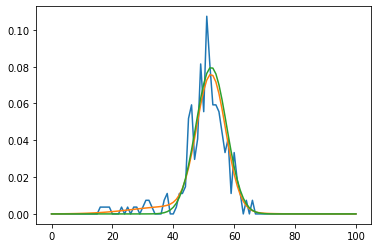

Power_divergenceResult(statistic=139827976359.0346, pvalue=0.0)


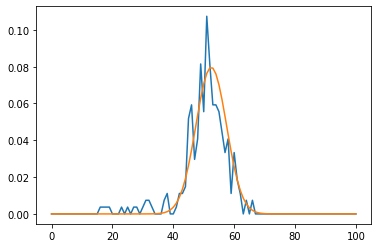

W,M,C [0.34431962 0.65568038] [[0.31405935]
 [0.24977857]] [[[22.66833399]]

 [[10.83624064]]]


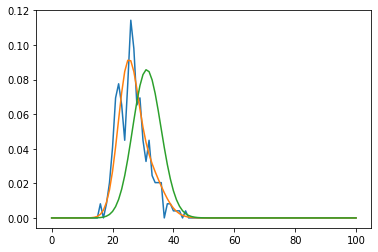

In [211]:
### Before and after ban
dist, data, peak2 = present_dist(not_debot, 2150,2420, 2, True, False, True)

print(chisquare(dist * (2430-2150), peak2 * (2430-2150)))

plt.plot(dist)
plt.plot(peak2)
plt.show()

X = present_dist(not_debot, 2475,2720, 2, True, False, True)

In [74]:
### predict 'events'
w = 150
p = get_pcnt(not_debot, 2424 - w, 2424 + w)
p1 = p[:w]
p2 = p[w:]
P1 = 0
P2 = 0
for i in range(w):
    if p1[i] < .4: P1 += 1
    if p2[i] > .4: P2 += 1  
print((P1 + P2) / w*2)

0.05333333333333334


In [267]:
loc = unpick('notbot_loc')
nbdm = bdm[not_debot]

In [268]:
TEST = [1, 20, 55, 66, 91, 104, 125, 193, 221, 265, 310, 330, 342, 368, 403, 462, 492, 568, 625, 649, 686, 695, 699, 740, 775, 796, 842, 852, 877, 914, 970, 980, 1003, 1019, 1030, 1164, 1538, 1604, 1684, 1739, 1779, 1789, 1791, 1934]

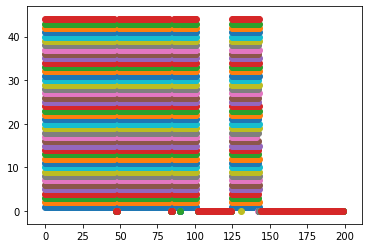

In [269]:
fd = 1900
ld = 2100
i = 0
for k in TEST:
    i += 1
    plt.scatter(range(ld-fd), nbdm[k][fd:ld] * i)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
(0.8075810373182211, 17, 34)


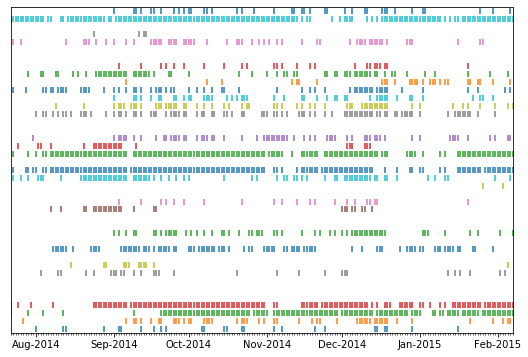

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
(1.0, 1, 2)


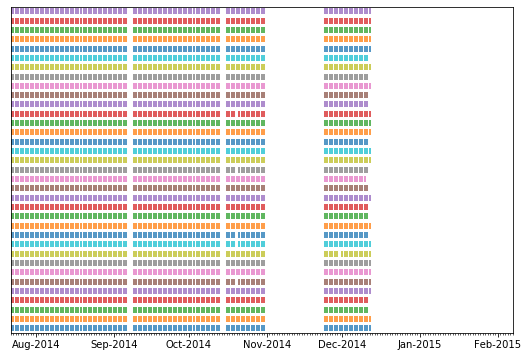

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(0.9757163671685284, 8, 50)


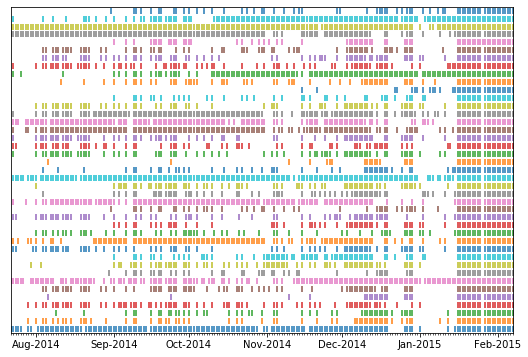

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0.9999999999999999, 12, 35)


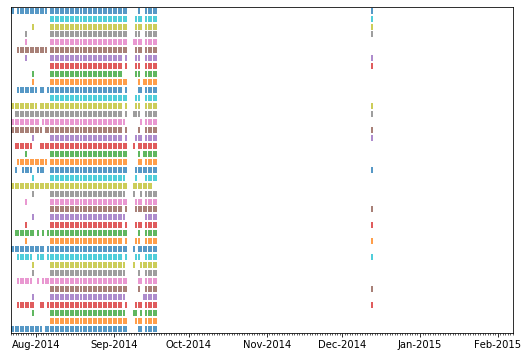

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(1.0, 13, 39)


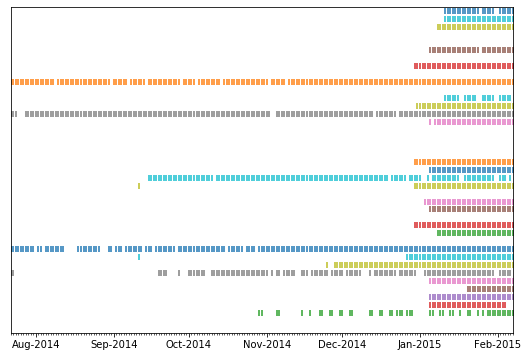

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


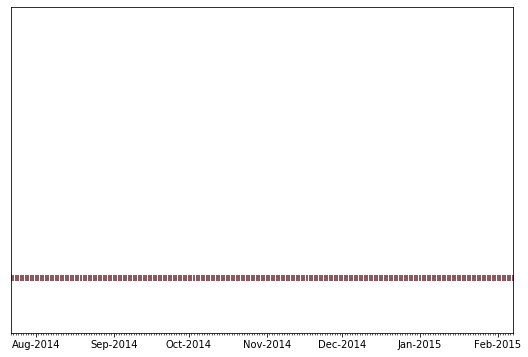

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


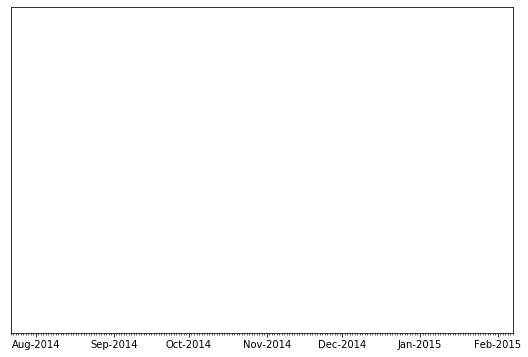

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 6)


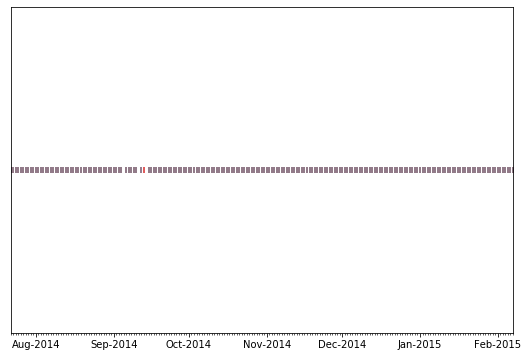

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(1.0, 1, 2)


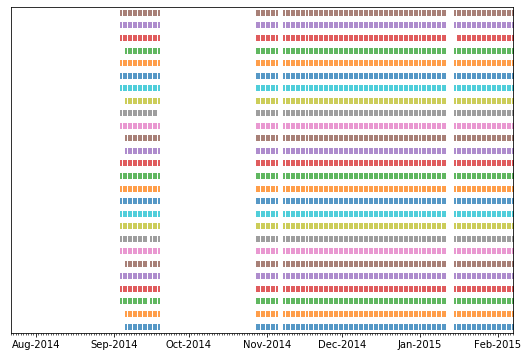

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

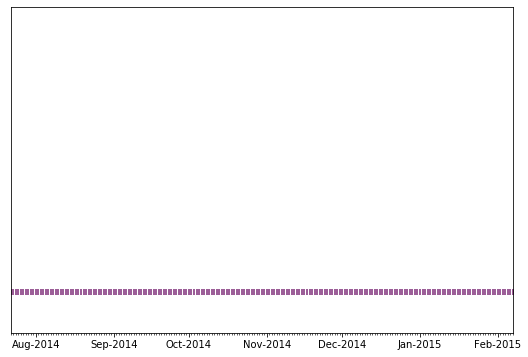

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


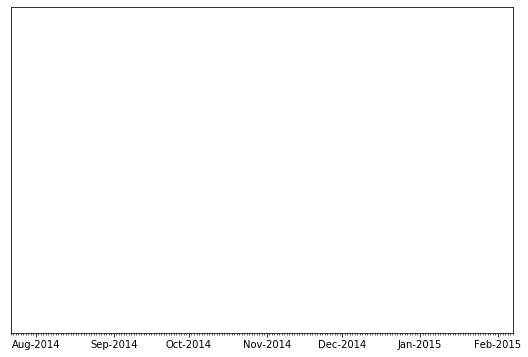

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

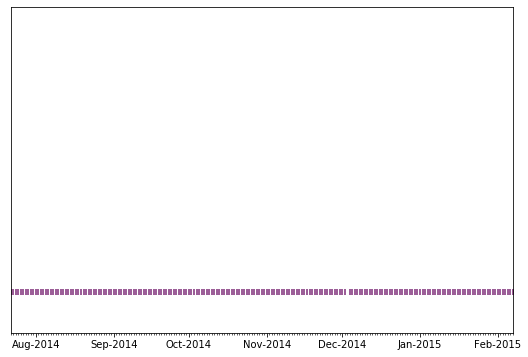

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


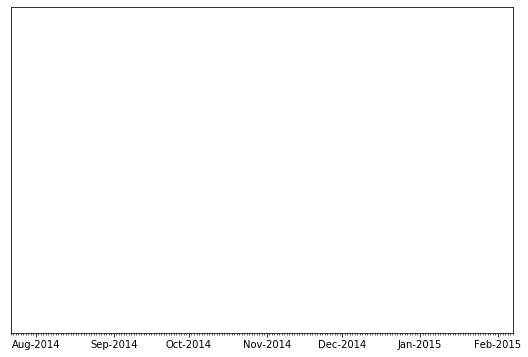

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


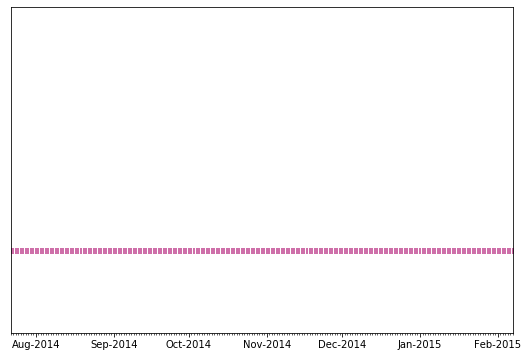

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(0.8306946106767414, 1, 2)


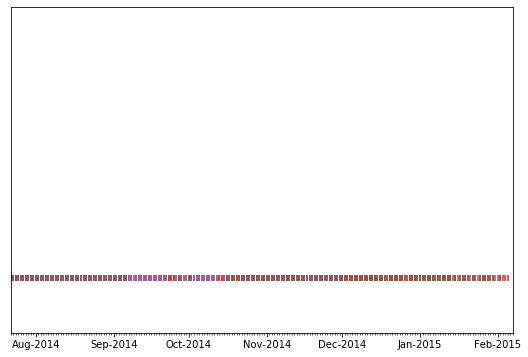

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
(1.0, 4, 12)


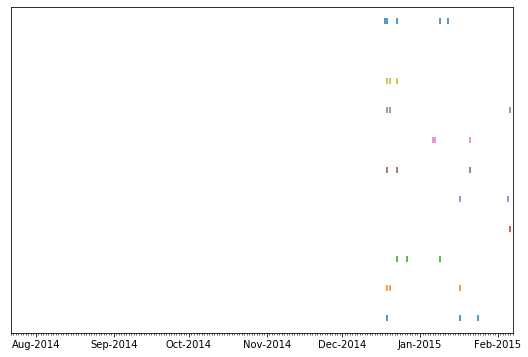

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 2)


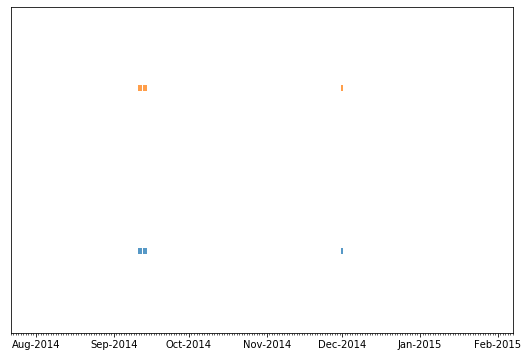

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 4)


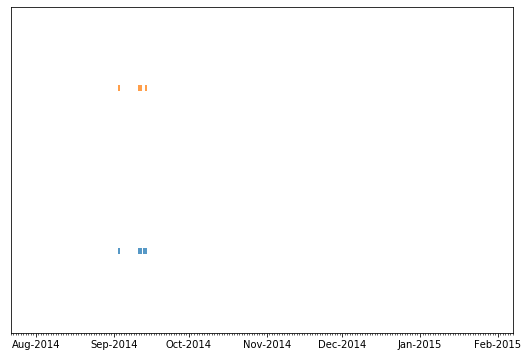

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


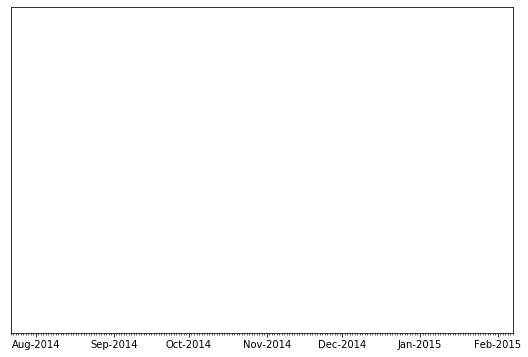

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

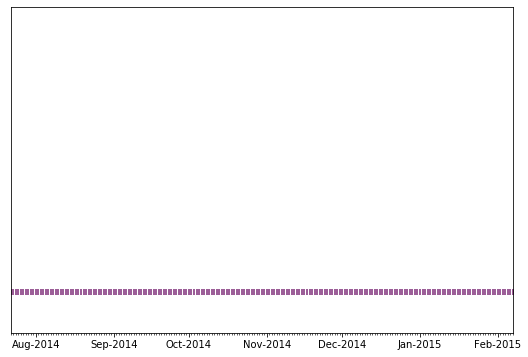

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 4, 6)


C:\Users\macki\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Attempting to set identical bottom == top == 0.5 results in singular transformations; automatically expanding.


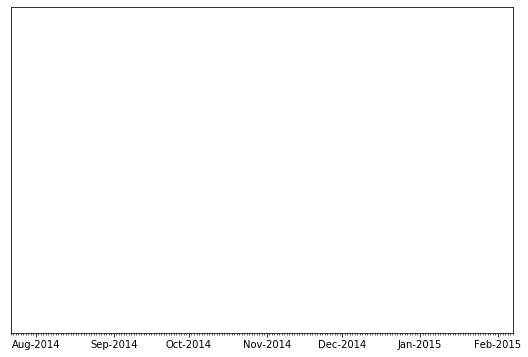

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


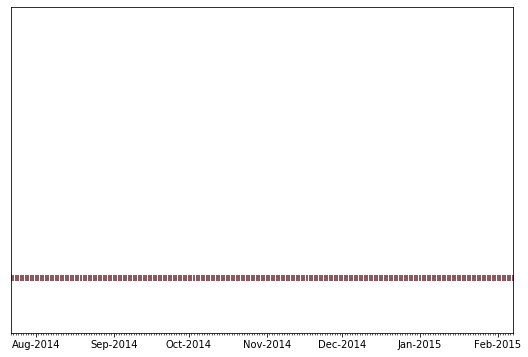

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 2)


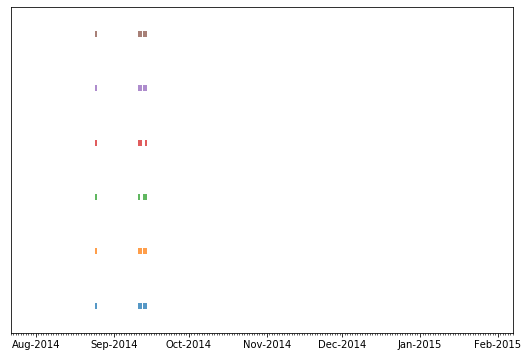

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 5)


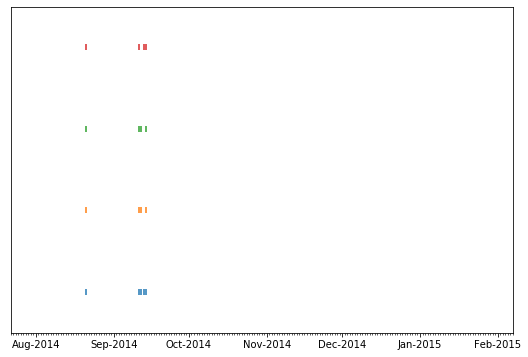

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


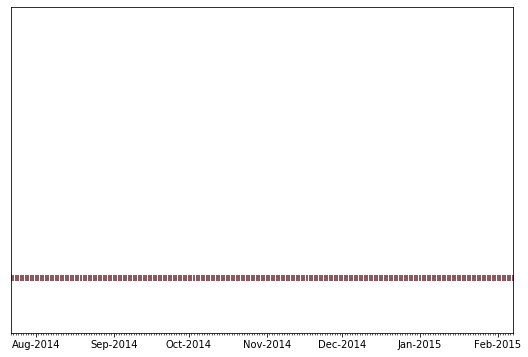

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


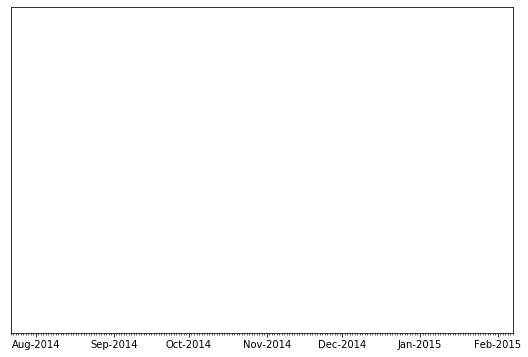

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


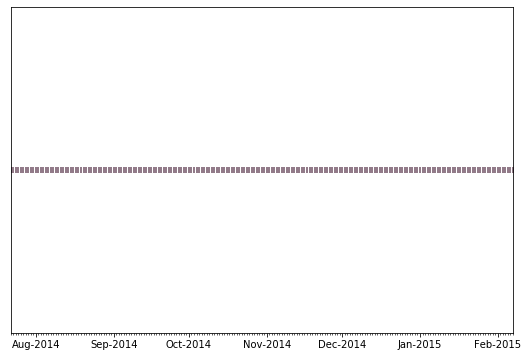

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


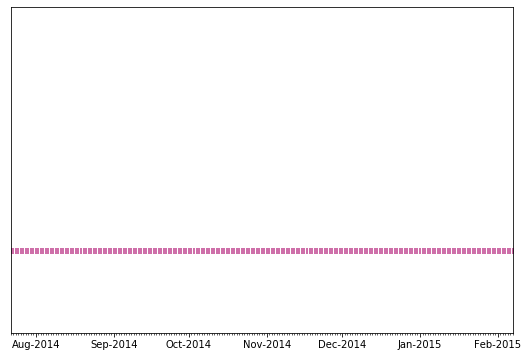

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


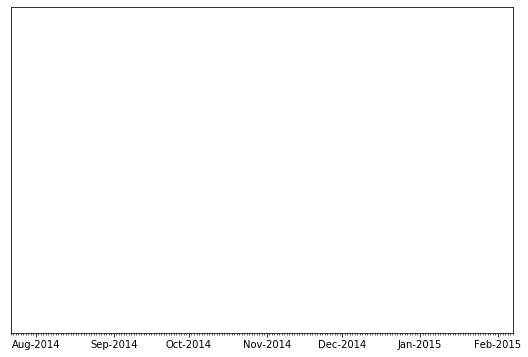

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0.9999999999999999, 1, 3)


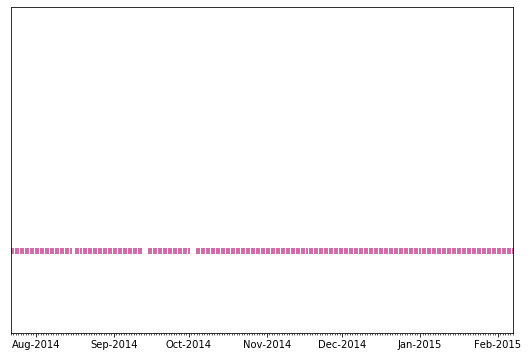

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


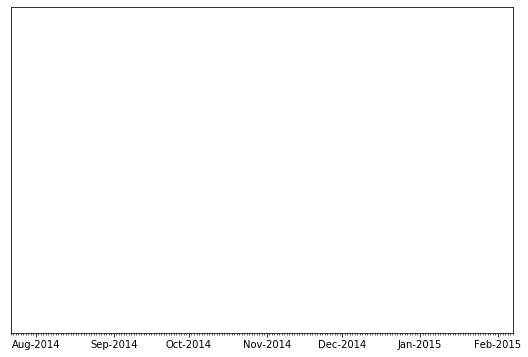

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

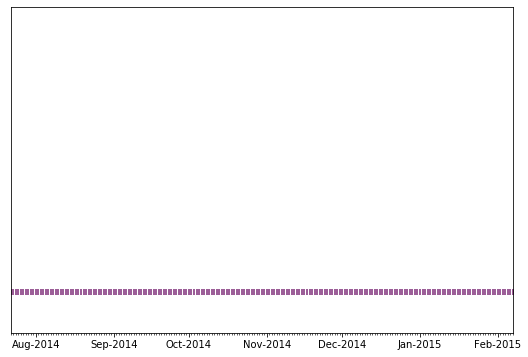

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


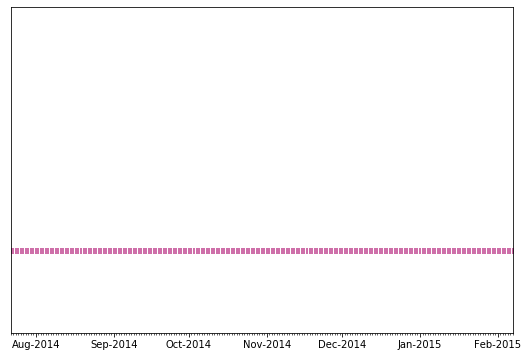

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


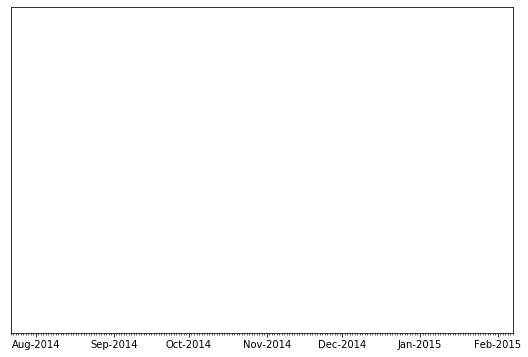

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 9)


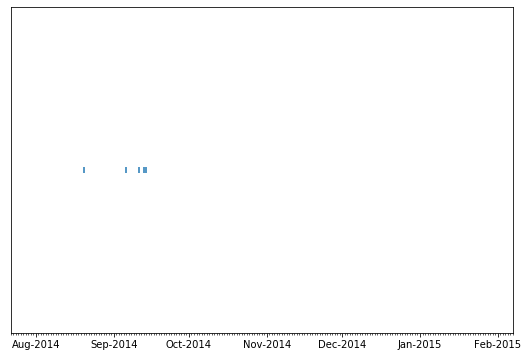

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


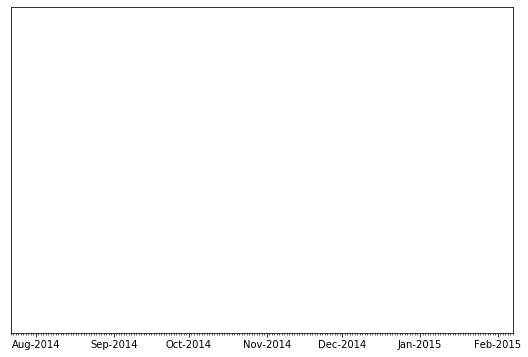

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 4, 6)


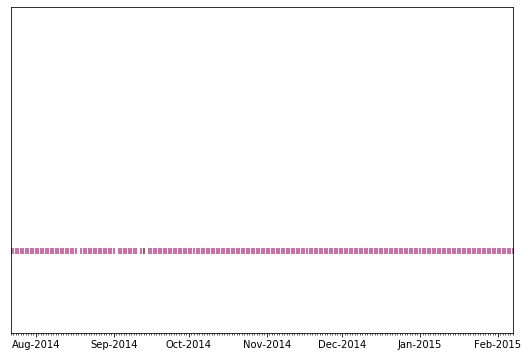

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0.9999999999999999, 3, 7)


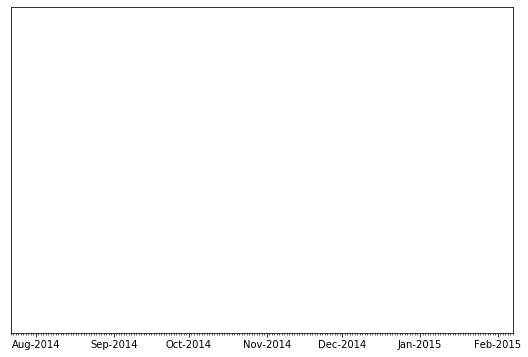

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

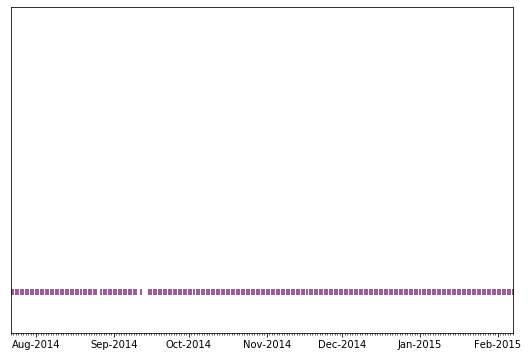

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

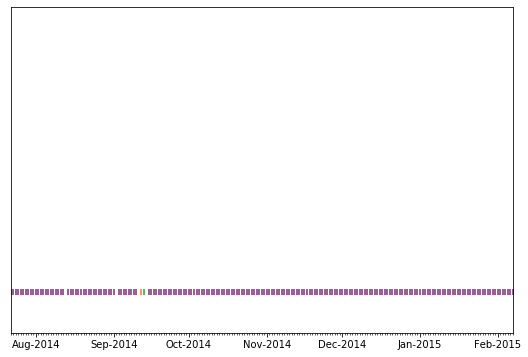

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

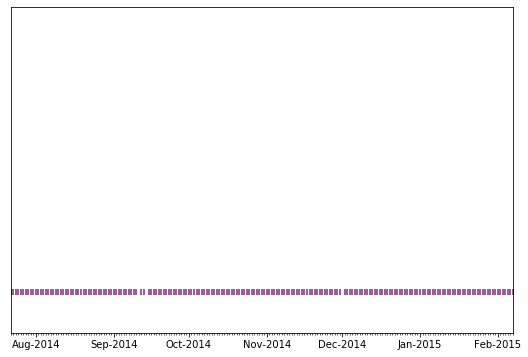

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

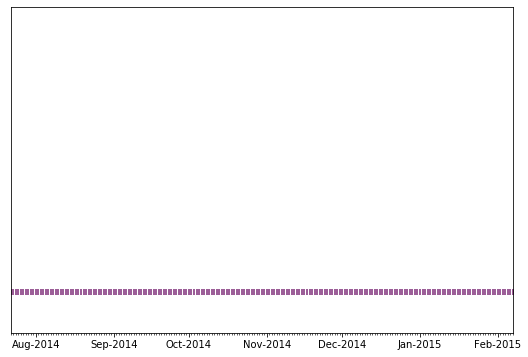

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

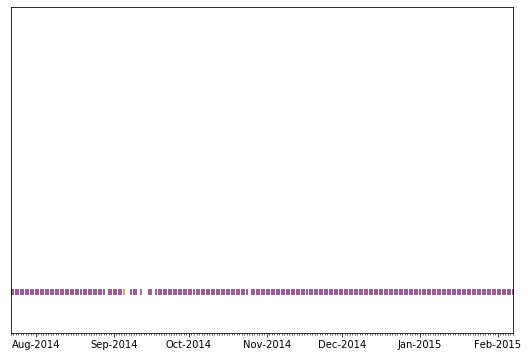

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


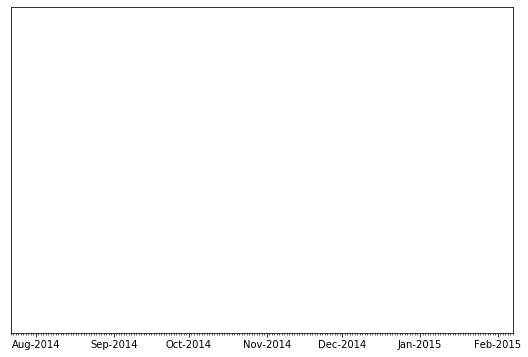

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


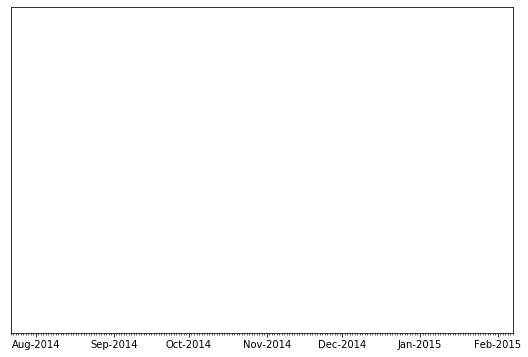

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


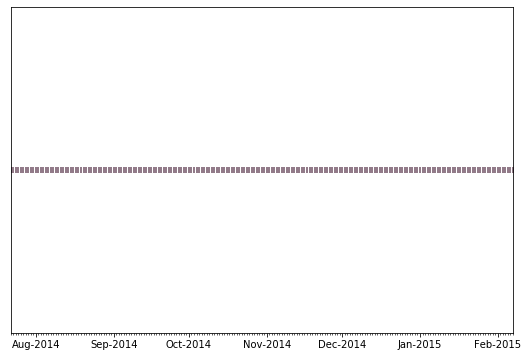

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

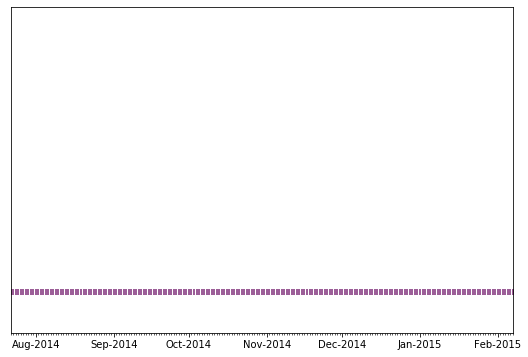

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

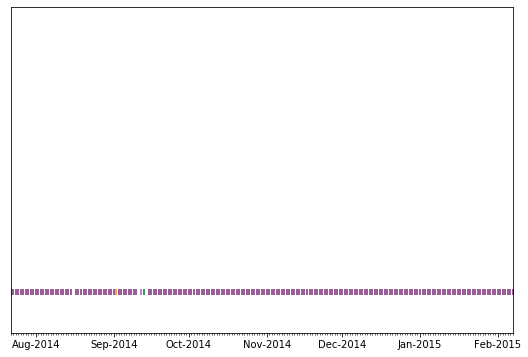

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


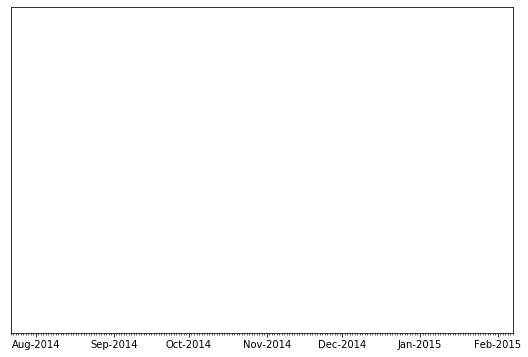

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 2)


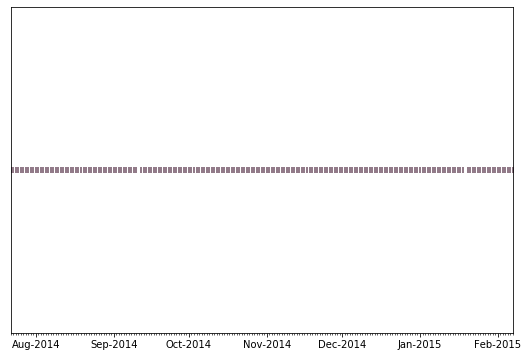

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(0, 0, 0)


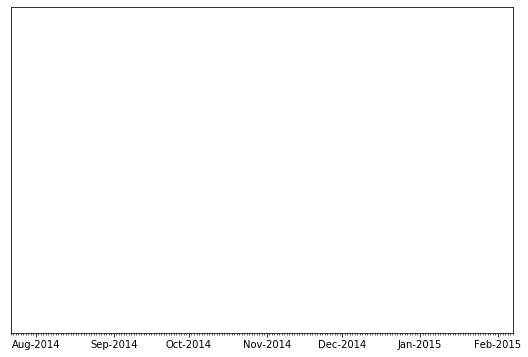

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1.0, 1, 2)


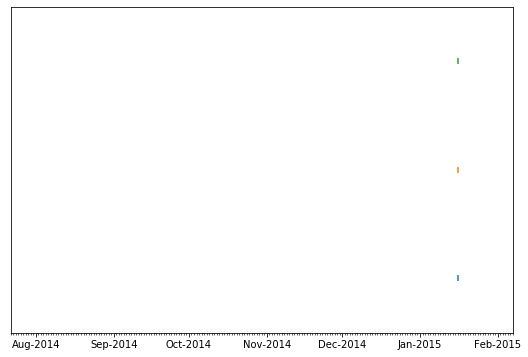

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

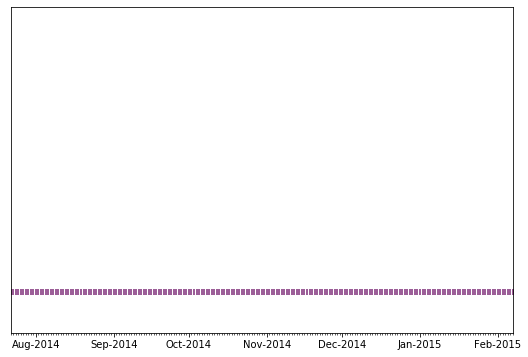

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

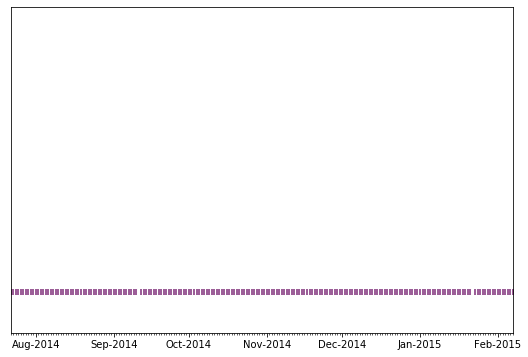

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

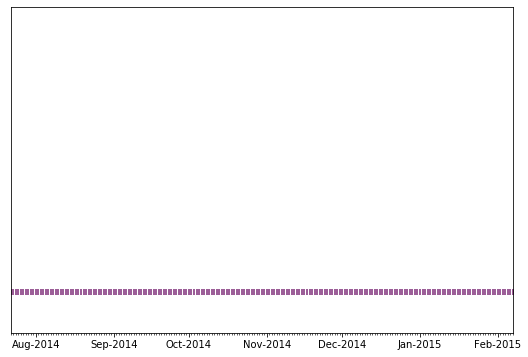

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

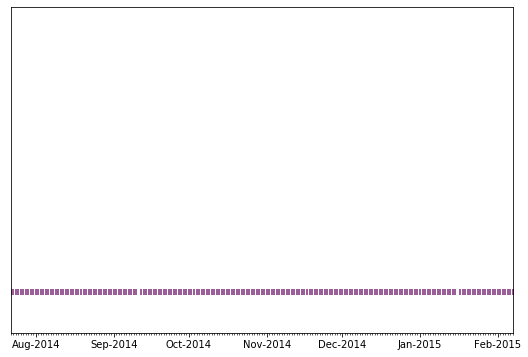

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 

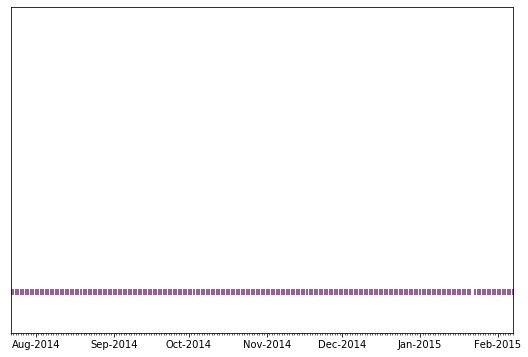

In [279]:
RES = []
for R in range(len(loc)):
    
    nd = loc[R]
    k = 0

    f, ax = plt.subplots(1,1)
    #if h > 30: h = 10
    f.set_figheight(6)
    f.set_figwidth(9)
    
    fd = 1900
    ld = 2100
    DATA = []
    
    for i in nd:
        k += 1
        x = nbdm[i]
#        if k == 22:print(i)
#        if k == 40:print(i)
        ax.scatter(day_x,x * k, marker = '|')
        DATA.append(x[fd:ld])
        if k == 50: break
    
    DATA = np.array(DATA)    
    RES.append(DATA)
    
    MAX = (0,0,0)
    
    print(DATA)
    DATA = np.corrcoef(DATA)
    x,y = DATA.shape
    for i in range(x):
        for j in range(y):
            if i < j:
                V = DATA[i,j]
                if V > MAX[0]: MAX = V,i+1,j+1
    print(MAX)
    
    #plt.autofmt_xdate()
    ax.set_xlim(num_date(fd),num_date(ld))
    ax.get_yaxis().set_visible(False)
#    ax.axhline(MAX[1], c = 'gray', linestyle = ':')
#    ax.axhline(MAX[2], c = 'gray', linestyle = ':')    
    #ax.axvline(num_date(2090 - 1), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 3), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 31), c = 'b', linestyle = ':')
    #ax.axvline(num_date(2090 - 33), c = 'b', linestyle = ':')

    from datetime import datetime
    import matplotlib.dates as mdates

    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months_fmt = mdates.DateFormatter('%b-%Y')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)

    plt.ylim(0.5,k+0.5 - 9)
    plt.show()

In [285]:
for nd in loc:
    temp = []
#    nd = loc[R]
    d = nbdm[nd]
    
    x, y = d.shape
    d = np.sum(d,0)
    for i in range(y):
        if d[i] < x/2: temp.append(d[i])
        else: temp.append(x - d[i])
    print(sum(temp), x)

176436 1449
304 44
34967 422
756 96
17195 67
16 6
208 17
6 8
153 35
228 5
91 36
0 5
30 29
182 7
435 6
540 20
7 11
9 11
10 15
27 5
10 9
18 6
8 15
9 13
0 6
90 19
60 8
4 7
0 46
5 7
28 24
30 5
0 7
41 10
8 10
11 12
5 7
16 9
2 5
3 5
0 5
0 5
5 5
0 51
0 12
0 8
0 5
4 5
0 10
0 8
0 13
0 12
0 5
0 5
0 5
0 5
0 5


In [ ]:
### Eng / Russian

In [2]:
### Likelihood
import numpy as np

In [35]:
x = np.random.binomial(1, 0.3, 100)

In [36]:
import sklearn
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
import time 

t0 = time.time()

t1 = time.time()
total = t1-t0

In [45]:
m = 0
mj = 1
mh = 1
for i in range(1000):
    y = np.random.binomial(1, 0.33, 100)
    c = np.corrcoef(x,y)[0][1]
    j = sklearn.metrics.pairwise_distances(np.array([x,y],bool), metric='jaccard')[0][1]
    h = sklearn.metrics.pairwise_distances(np.array([x,y],bool), metric='hamming')[0][1]
    m = max(c,m)
    mj = min(j,mj)
    mh = min(h,mh)
print(m)
print(mj)
print(mh)

0.31024405008643596
0.6666666666666666
0.27


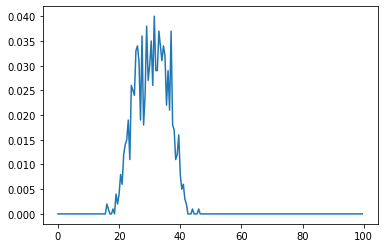

In [95]:
### Generate data using our model
p = 0.38
q = 0.26
e = 0.6
users = 200

for k in range(1):
    events = np.random.binomial(1, e, 1000)
    data = []
    for i in range(1000):
        event = events[i]
        if event == 0:
            posts = np.random.binomial(users, q, 1)
        else:
            posts = 0
            prob = p
            for j in range(users):
                x = np.random.uniform(0.5,0.8)
                posts += np.random.binomial(1, x * p + (1-x) * q, 1)
        data.append(posts)    
    
    ocs = []
    for i in range(users):
        ocs.append(data.count(i))
    plt.plot( np.array(range(200)) / 2 ,np.array(ocs) / 1000)
#present_dist(all_users, 1750,3000, 2, True, False, False)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXoAAAD4CAYAAADiry33AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nO3de3hc913n8fd37rp4ZFuWrSR24msTnJTeTJKGFrqkF7dA3S7pkgIP5XnykO1ClkKXXdpl6bYFdrfAElgIlzyEJYSFtISWGgh1IQmX0jatQ9ImTuJGdpzYcWTJkSNZl7n/9o9zzmg0Hlmj0ZlIc+bzep481hwdyWcymo+/+v5+5/cz5xwiIhJdsdW+ABERaS8FvYhIxCnoRUQiTkEvIhJxCnoRkYhLrPYF1Nu0aZPbvn37al+GiEhHeeSRR84654YafW7NBf327ds5fPjwal+GiEhHMbPnFvucWjciIhGnoBcRiTgFvYhIxCnoRUQiTkEvIhJxCnoRkYhT0IuIRJyCXkKVK5b588MnaWb562Pj0/zzM+OvwFWJdDcFvYTqH46O8Z/v+yZPvji15Lm/9cAz3Panjzb1j4KItE5BL6GaLZQBmJwtLnnu6ckck3NFxqfz7b4ska7WVNCb2X4zO2pmI2b2kQafT5vZp/3PP2xm2+s+f7mZTZvZz4Zz2bJW5UsVAKZySwf9makcAMfGZtp6TSLdbsmgN7M4cAfwTmAv8H4z21t32i3AOefcbuB24FN1n78d+NuVX66sdfmiV9FPzZUuep5zjtFJL+hHxqfbfl0i3ayZiv5aYMQ5d9w5VwDuBQ7UnXMAuNv/+D7gRjMzADN7D3AcOBLOJctaFlT0k3PzFf3fPv4in3v01ILzJueK1XOPjSnoRdqpmaC/DDhZ8/iUf6zhOc65EjAJDJpZH/BzwCcu9heY2a1mdtjMDo+PaxZGJ2vUurnrS8/yib96klK5Uj026rdtwJt9IyLt00zQW4Nj9dMkFjvnE8DtzrmLvpOdc3c65/Y55/YNDTVcTlk6RK7aupkP+qlckZdni3zt2YnqsRf9ts3lG3sZUUUv0lbNBP0pYFvN463A6cXOMbMEMABMANcBv2JmJ4CfBv6rmd22wmuWNWy+op/v0Qf9+kNHRqvHzvhB/527N/HiZI7p/MV7+iLSumaC/uvAHjPbYWYp4GbgYN05B4EP+B/fBDzoPG92zm13zm0HfgP4H8653w7p2mUNypcaV/QAh46coVLxfhkMWjffuXsQgONq34i0zZJB7/fcbwMOAU8Bn3HOHTGzT5rZu/3T7sLryY8AHwYumIIp3SFfXDgYWyxXmC2U2bGpj9GpHE+cngS8qZWb+lNcNZwFUPtGpI2a2krQOXc/cH/dsY/VfJwD3rfE9/h4C9cnHaZ+MDao7G/YNcizZ2d4fmKWb9+6ntHJHFuyGTb1p4CFs3REJFy6M1ZCNd+68XruQa9+64ZeYD7QR6fyDGczpBLej2ChVKn/ViISEgW9hGqxin7bxh7/sRf8Z6ZybBnIkIwr6EXaTUEvoQp69LOFMsVypVrBb8lmSMaNqVyRfKnMxEyB4WyGRMww83r5ItIeCnoJVc5v3YBXzQeV/UBPkmwmydRckbEpbxGz4WwGMyMVj5FX0Iu0jYJeQhVU9OD154NWTTaTJNuTZCpX4qWZAgCb1nkDsalETK0bkTZS0Euo8qUyPck4sLCiz/YkyPYkmZwrcs4P+g29ftDHFfQi7aSgl1DlSxU2Z9OAN8Nmcq5IImb0JONkMwmm5orVin6wzztPFb1IeynoJVT5UoXN67wAn8oVmZorMtCTxMz81k1NRd+XBLyg12CsSPso6CVU+WKZoSDo50pM5Upke7xA9wZjS0zMFkjGjf60d79eKh6joKAXaRsFvYQqX6ow1L+wos9mvEDP9nitm4npAht6U/hbFpBUj16krRT0EhrnHPlShYGeJMm4VXv0QUU/0JOkUK5wenKOjX2p6telErHqjVYiEj4FvYQmaL+kk3EGepLVWTfZzHzrBuC5l2YvCHr16EXaR0Evocn5c+jTiZjXj/fn0Vd79P6fp87NsqEm6NOadSPSVgp6CU2woFk6GWfTujQnzs54FX2P36P3e/UVB4M1QZ/UYKxIWynoJTT5mor+LVcO8fgLkxRKlWrLZsCv6GH+ZinQDVMi7aagl9AEA6qZZJx3XD1cPV7fugEa9OjrtyEWkbAo6CU01dZNIsauoX72bO4H5iv5oLIHFvTodWesSHsp6CU0QUWf9jcTCar62nn0gUFNrxR5xSjoJTTzPXpvUbMfeMNW9l6Sre4Lm07EySS9H7kLe/RlRKQ9mtozVqQZ87NuvDDfsamP+z/05gXnZDNJcsX8BT16zboRaR9V9BKa2nn0iwkGZIMFzcCr6DUYK9I+CnoJzfxgbHzRc7KZBP3pxIJzUokY5YqjXFHYi7SDgl5CUz8Y28hAT3JBNQ9og3CRNlOPXkJTDfrk4kH/g9+xjTP+nrGBVGI+6HtSi/82ICKtUdBLaPJFr3WTSS4e1vuvueSCY9Wg14CsSFuodSOhaaZ100g6rqAXaScFvYQmCPpUfHk/VsmEtwGJevQi7aGgl9DkS2XSiVh156hmpeJeq0dBL9IeCnoJTb5YWXbbBhYOxopI+BT0Epp8qUz6IgOxi9FgrEh7KeglNK1W9Mm4evQi7aSgl9DkS60FfVoVvUhbKeglNPlS+aJz6BejwViR9lLQS2hareiDHn1RFb1IWyjoJTRej34Fg7Gq6EXaQkEvofFm3WgwVmStUdBLaFbausmrdSPSFgp6CU2uWG6pdZP2B2OLquhF2kJBL6FZaUWv6ZUi7dHUu9LM9pvZUTMbMbOPNPh82sw+7X/+YTPb7h+/1swe8//7hpm9N9zLl7UkX6qoRy+yBi35rjSzOHAH8E5gL/B+M9tbd9otwDnn3G7gduBT/vEngH3OudcC+4HfNzOtgR9R+RZbN4l4jJgp6EXapZny61pgxDl33DlXAO4FDtSdcwC42//4PuBGMzPn3KxzruQfzwDaFHSNcc7x+cdeCGUOe75UIdNCRQ9e+0atG5H2aOZdeRlwsubxKf9Yw3P8YJ8EBgHM7DozOwI8DnywJvirzOxWMztsZofHx8eX/yykZUdOT/Ghex/jwafHVvR9SuUKpYprqaIHbw17VfQi7dFM0DdaXLy+Ml/0HOfcw865q4HvAD5qZpkLTnTuTufcPufcvqGhoSYuScIyW/C2/zv98tyKvk9QjbcyGAuq6EXaqZl35SlgW83jrcDpxc7xe/ADwETtCc65p4AZ4JpWL1bCF1TRo1O5FX2ffHGFQa+KXqRtmnlXfh3YY2Y7zCwF3AwcrDvnIPAB/+ObgAedc87/mgSAmV0BXAmcCOXKJRSFslfRn5lcWdDnSt73aWU9evAregW9SFssGfR+T/024BDwFPAZ59wRM/ukmb3bP+0uYNDMRoAPA8EUzDcB3zCzx4DPAT/hnDsb9pOQ1rVS0d/95RM89eLUgmMrrugTMS1qJtImTU11dM7dD9xfd+xjNR/ngPc1+Lp7gHtWeI3SRoWyN9xyZirf1PnOOT7xV0f4sRt28LHvn59lG2wM3upgbFKtG5G20Z2xXa5a0U/mcG7p2a/5UoWKg6lcse6437rRYKzImqOg73JB0M8Vy0zNXTDz9QIzee+cqbn6oPe+Tysbj4A3GJtXRS/SFgr6LlfwK3Fork8fTMecrA/6oEe/ghum1KMXaQ8FfZcrlufbNcsJ+qncwup/pa2btGbdiLSNgr7L1fbFm5liOVO4eOtGg7Eia4+CvsvV9sWbqejnqhW9BmNFOoVWkuxyhVKFVDxGfybRVNAHg7HncyXKFUc85q1+kVtpj14VvUjbqKLvIpWKo1JZOIWyUKqQSsTYks0saN0E51YqbsG0y7ni/ODtdE2fPl8MKvrW74zVYKxIe6ii7xLfPPUyN/3eVyiUKtzyph38wvd5NzsVyxWScWM4m65W9Hc8NMKvHjpa/dqrL83yNz/1ZgBm8vNBP5UrMtCbBGp79K23bmYLZSoVRyzWaI08EWmVKvoucWx8mkKpQl8qztHR89XjQUU/PJDhjB/0h09MMJzN8DNvfRU3XrWZI6enODdTAGC2MF/F106xXGnQv2bremYLZR49+XJLXy8ii1PQd4mgEr9kfU914BS8WTdB6+bsdIFCqcLoVJ69l2b50Fv38CPXXwF4/1DA/PRKWDggmy+VScSMRLy1H6l/c9VmEjHji0dGW/p6EVmcgr5LBLNlNvamFsy0CQZjh7PeNgFj53OcmcqxxX+8e3M/MB/0MzUVfe0Uy3yxtY3BAwM9Sd64a5BDR0abWopBRJqnoO8SQUAP9Card7GCV9En4zG2DHjB/vzELBMzhWrwX7q+h3QixsiYF/RztRV9zZIJ3sbgrQ3EBt5x9TAnXprl758aY+z8ypZNFpF5CvouMVcok0nG6E3FF7ZuSl4lHgT746cmARgeSAMQjxk7h/qrQT+TL7Mu443h17duVlLRA7z96i3EY8aP//Fhbvy1f7xghpCItEZB3yVmCiV6UwnSiVh1zjvUDMb6Qf+NU95gaNC6Adg11Mex8RnAG4zdvC6N2cLWTW6FrRuAzesyfPY/3MB7X3cZ5/Ml3UAlEhIFfZeYzZfpTcVJJ+INB2PX9yZJJWJ842RQ0c8H/e7N/Zw8N0uuWGa2UKY/nWBdOlE366bc8hz6Wq/Ztp6rL81Wr01EVk5B3yVmC2X6/Iq+djC2WPYGY82M4WyGF/xNwi/J9lTP2b25H+fg2bMzzPq/GQz0JhcsbOb16MP5cUr5vxnUjiWISOsU9F1iplCiJxUnk4xfMOsm6U+JDNo3mWSMbM/8vXS7hryZNyNj094/GOk42Uwy1Fk3tYLvo4peJBwK+i4x5wd0OhGjXHGU/BANevQw364ZzmYwm787dcemPiCo6Mv0pBJe0NcNxra66Ui94Hq09o1IOBT0XWKmUKYnmai2V4KqPt8g6GsHYsHbNWqwL8XoVI7ZQom+VJxsT32PPryKPhWP+9+zvMSZItIMBX2XmC2U/Io+CFG/oi/PB3QQ8LUDsYFg0bPZfJmeVNC6qevRhzAYCzWtG1X0IqHQomZdYrZQrk6vhPlquVi+sEc/nL0w6IcHMoxO5ZgplOhLJYibhT6PPlAdjFXQi4RCFX2XmM2XvOmVyYUzWoIlEGD+Jqn61k1w7PmXZqk46E3HyfYkmS2Uq0sL54vhzbpRRS8SLgV9F3DOMVss05eab93k/Iq+djB29+Z1XDW8jmt3bLzgewxnM5z3Nx3pTcbZ4C9PHKxqmSuGM48eNBgrEja1brpArljBOeipbd0UK1QqjlLFVYN1oCfJF376uxp+j6DaB+hNJxjo8YJ+dCrH5mwm3MHYuvaSiKyMKvouECxo1peOV6dA5kuV6jz1VBMBXdvO6Uslqn380ckczrlQg75+wFhEVkZB3wWCFSfrB2OrQd/EGvK1M3F6U/Hq4zNTuer3WenqlQH16EXCpaDvAkFF31vTo88XK9Ugbaair52J05uKs6k/TTxmjE7lVry7VL20Zt2IhEpB3wWC3aUWzLop1QR9ExX9QE+yGsC9qQTxmLF5XZrRyXx1Bk9YFb0GY0XCpaDvAou1borL6NGbWbVd05v2An1L1ttnNhg01Tx6kbVJQd8FGrZuair6ZJP7vAYDsn0pb7LWcDbTltZN8BuGKnqRcCjou0BQ0fel5yv6XLFcDehmKnqY79P3pLx/LIYHvGURcsWgog+ndZOIx4jHjEJZ0ytFwqCg7wILKvraHv0yWjcAlwStm9R86+Z8vsS5GW8phLDujAWvqtd69CLh0A1TXWC2djC2waybdJOtmx+67nJ2bOqbXxvHv4nquQlvm8GwWjfg/aOh9ehFwqGg7wKzNYOx8ZiRjNuyB2MBrhjs44rBvurjoGf/3EuzAKGtRw9eRa8evUg41LrpArOFEumE1/cG/H1jlz8YW2+4GvTtqeg160YkHAr6LuBt/zf/y5u3b2x5WTdMNRJMt3z2bBD0quhF1iIFfReYKZToqWmrpBPeQOdyB2Pr9aYSbOhN8q0z04C3lk5YUom4FjUTCYl69F1gNl9eEMLpZHzZd8Yu5vd+5A0cPXOeTf1pLhnoWfG1BrzfOlTRi4ShqXe4me03s6NmNmJmH2nw+bSZfdr//MNmtt0//jYze8TMHvf//J5wL1+aMVv0NvQOpBMxcsXyiit6gOt2DvKjb9zOu159yYqvs1YqodaNSFiWfIebWRy4A3gnsBd4v5ntrTvtFuCcc243cDvwKf/4WeD7nXOvBj4A3BPWhUvzZvPeht6BoFoOo6JvF1X0IuFp5h1+LTDinDvunCsA9wIH6s45ANztf3wfcKOZmXPuUefcaf/4ESBjZmnkFRXsFxvwWjcrH4xtp7QqepHQNPMOvww4WfP4lH+s4TnOuRIwCQzWnfMDwKPOuXz9X2Bmt5rZYTM7PD4+3uy1S5PmiuXqsgXQoKJfg0GfSuiGKZGwNPMOtwbH3HLOMbOr8do5/77RX+Ccu9M5t885t29oaKiJS5LlqN0AHPx59MVK9YapRKzRy7e60pp1IxKaZoL+FLCt5vFW4PRi55hZAhgAJvzHW4HPAT/qnDu20guW5SuWK6QS82Hu3YxUJl/2NgY3W3tBr3n0IuFpJui/Duwxsx1mlgJuBg7WnXMQb7AV4CbgQeecM7P1wN8AH3XO/UtYFy3LUyxXFtz9Wtu6aXadm1daSoOxIqFZ8l3u99xvAw4BTwGfcc4dMbNPmtm7/dPuAgbNbAT4MBBMwbwN2A38gpk95v+3OfRnIRdVLLu6oJ+fR78W+/OgwViRMDV1w5Rz7n7g/rpjH6v5OAe8r8HX/RLwSyu8RlmhQrlCIl7TuvHn0RfLazfoNY9eJDxr810uoSqWFw7GZmrujG11QbN2SyVilCqOcqV+3F9ElmttvsslNOWKwzku6NEXShXya7p1400HVVUvsnJr810uoQmmUC4Ien8nqOl8aU3eFQvzc/sV9CIrtzbf5RKaQjXoa3v0XrV8PldawxV9sOWh5tKLrNTafJdLaIoNNhcJQvSZM+erm4esNalq0KuiF1kpBX3EFcveYGajoJ8plHnb3i2rcl1LSSvoRUKjoI+4YqPWjb8JSTxm3Phta/O2hrR69CKhUdBHXKMNwIMQvX7nRtb3plblupZSHYzVwmYiK6YdpiKuUesm41f077h6eFWuqRnBgPHDx1/i4wePUHGOn3jLbvZfs3avWWStUkUfcY1WqHzd5ev54esu58Br61ebXjuCiv7gN07zxAuTPD16nn84OrbKVyXSmVTRR1x1emVN6yabSfLL7331al1SU4L5/c+cmWbXUD+zxZL69SItUkUfcSW/dbNWb4xaTHBTV6FcYdfmPlJxrWYp0qrOevfLsjW6M7YT1P7DtHuov7ripogsX2e9+2XZGt0Z2wlqZwnt2tzvr0+vu2RFWqGgj7hGd8Z2gmDWDcCuoX6tTy+yAp317pdlazS9shMsqOiH+rVZuMgKdNa7X5at0Z2xnSC4qeuy9T30pOLe9odFBb1IKxT0Edfpg7G7N/cDXitHFb1Iazrr3S/LFrRu1upyxIuJxYxsJsFVl6wDtLWgyErohqmI69SKHuDPP3gDl6z3llH25tFr1o1IKxT0EVddAqHDevQAVw6vq36cTqqiF2lV55V5sixBX7vT7oytpztjRVrX2e9+WVKpQ6dX1lNFL9K6zn73y5KK5Qox8zYZ6WSpeJxSxVGuuNW+FJGOo6CPuEK50vHVPNRsRKKqXmTZOj8B5KKKJReJoNfWgiKt6/wEkIsqlisdd1dsI6nqZuGaYimyXAr6iCtVotG6SVeDXhW9yHJ1fgLIRRUi0rrRZuEirev8BJCLKpYrHbf8QSPVil4Lm4ksW+cngFxUsVxZsDF4pwrWp1dFL7J8CvqIK0ZsemW+qMFYkeXq/ASQiyqWHckItG7UoxdpXecngFxUsVwhFYHplZpHL9I6BX3ERa51o6AXWbbOTwC5qELZkYhA0FcHYxX0IsvW+QkgF1UsRaN1o7VuRFqnoI+4qNwZG6ynryUQRJav8xNALqpYjsadsemkevQirer8BJCLKpSiVtEr6EWWq6kEMLP9ZnbUzEbM7CMNPp82s0/7n3/YzLb7xwfN7CEzmzaz3w730qUZ3hIIEejRx9WjF2nVkkFvZnHgDuCdwF7g/Wa2t+60W4BzzrndwO3Ap/zjOeAXgJ8N7YplWbwlEDq/oo/FjFQ8phumRFrQTAJcC4w454475wrAvcCBunMOAHf7H98H3Ghm5pybcc59CS/wZRWUItKjB2/mjRY1E1m+ZhLgMuBkzeNT/rGG5zjnSsAkMNjsRZjZrWZ22MwOj4+PN/tl0oRCuUIyAq0b8O6OLZQ160ZkuZoJ+kYpUb9DczPnLMo5d6dzbp9zbt/Q0FCzXyZN8JZAUEUv0s2aSYBTwLaax1uB04udY2YJYACYCOMCpXXliqPiiFTrRj16keVrJgG+Duwxsx1mlgJuBg7WnXMQ+ID/8U3Ag865pit6Cd/ETIHpXAmARATujAW/daNZNyLLlljqBOdcycxuAw4BceAPnXNHzOyTwGHn3EHgLuAeMxvBq+RvDr7ezE4AWSBlZu8B3u6cezL8pyK13vs7/8Kbdm8CiFbrRkEvsmxLBj2Ac+5+4P66Yx+r+TgHvG+Rr92+guuTFuRLZZ57aZbBvikgQq2buCp6kVZEIwFkgbGpPAAnz80B0Qn6dCKuoBdpQTQSQBYYnfJuWxg/7wV+MiI9eq91o+mVIsuloI+g0cmF96dFp6JXj16kFdFIAFngzFQ0gz6lWTciLYlGAsgCF1b0UWrdKOhFlktBH0GjUzliNdmeTETjZU4n4rphSqQF0UgAWeDMVI5XbVlXfRyVefTpRIx8UYOxIssVjQTocsfGp/nvn3+Cj33+CZ4enWJ0KseVw+uq+6wmYtFo3aRrlkA4nyvye/94jHJFN2CLLKWpG6ZkbfuTrz7HH3/1OeJmjE3lOTOVZzibYTib4fmJ2ci0boIevXOO+x9/kf/1t09z7Y6NvP7yDat9aSJrWjQSoMuNjE1zzaUD/OB3bOOBp89QKFXY4gc9RKd1k4rHcA5KFcfI2DQAZya11YHIUqKRAF3u+PgMu4b62H/NMMWy18oYHsiwZcAL+qhMrww2CC+UKhwbnwHmbw4TkcVFIwG62Ey+xAsvz7F7cz/X7xwkm/G6ccMDGS6pBn00evS1G4QHFb2CXmRpCvoOd9yvbHdv7icZj3Hjt20BYDibYUs2WhV9KhEHYGquyMlzs8DC1s2fPvw8f/LV51bl2kTWMg3Gdrhj415lu2uoH4Aff/NO+tMJhrMZ3r53C8fHp6uVfafbvqkXgL987AWC3Q6Cir5UrvCrh57mkoEefuT6K1brEkXWJAV9hxsZmyYeM64Y7ANg76VZfvE91wCwbWMvv/zeV6/m5YXq2u0bWd+b5I++fAKAnUN9nPFX6vz6iXOcmy2S9qt+EZkXjd/pu9ix8Wmu2NhbnTMfZYl4jBuv2sLLs0XM4IZdg7w4OYdzjkNHRgGYmC2gzc1EFop+OkTcyNg0uzb3r/ZlvGL2XzMMwNYNPWwf7CNXrDA5V+SLftAXShVmC7p7VqSWgr6DlcoVTrw0w+4uCvo379lEbyrO7qH+6mDz3z81xunJHNfu2Ah4++WKyDz16DvY8xOzFMuuOhDbDTLJOL958+vYkk1XV7K8+8sniMeM971hK197doKJmQLbNvau8pWKrB0K+g4WzCXvpooe4G17vSmkJye8KZaPvzDJG3cOVltYE7Oq6EVqqXXTwYK7Q3cO9a3ylayOzdl09eP91wyzsTcFwDm1bkQWUNB3oGDf1JGxabZk02QzyVW+otWRTsTZ2OeF+9uv3sIG/2P16EUWUtB3mOl8iTf84t/zl4++wMj4dFf15xvZtqGH12xbzyUDPWQzCRIxU9CL1FGPvsOMTs4xnS/xF/96iuNj07z39Zet9iWtql//wddW18AxMzb0pTinHr3IAgr6DvPStBdiXxo5i3PdNxBbr/43mo29qer/IxHxqHXTYYJqNbj5s9tbN/U29CVV0YvUUdB3mImZIgA9SW9Nl26v6OsN9qXVoxepo6DvMBMz3iJe79u3lS3ZNJvXpZf4iu6yoS+poBepox59h5mYKdKfTvDfvncvP/PWV2EWjU1FwrKxN8XLc0XKFUc8Ipuii6yUKvoOc262wIa+JKlErDpvXOZt6EvhHEzOFVf7UkTWDAV9h5mYKVTvAJULbdRNUyIXUNB3mImZgir5i1DQi1xIQd9hJmYK1TCTCw35g9MvTs6t8pWIrB0K+g5zblatm4vZPtiH2fym6SKioO8ouWKZ2UJZrZuLyCTjbNvQy4i/abqIKOg7StB3Vuvm4nZv7ufYmIJeJKCgX+MeenqMzxw+CSjom7VrqI/jZ2coV7x1Ir587Cz3fOXEBec9eXqK33rgGW0mLpGnoF/jfvFvnuS/f/4IuWK5uoaLgv7idm/up1CqcOqctwPVr3zhKB//qyd5uW4NnDseGuF//923eEbVv0Scgn4NGxk7z/HxGeaKZf75mbPVin6DBmMvKlj/59j4NKOTOR47+TLliuOBp8aq5+SKZR466j0+9MToqlynyCulqaA3s/1mdtTMRszsIw0+nzazT/uff9jMttd87qP+8aNm9o7wLj36vuAHUF8qzheeGFXrpknBip4jY9N88Unv/2F/OsEXjswH+peeOctsoXzBcZEoWjLozSwO3AG8E9gLvN/M9taddgtwzjm3G7gd+JT/tXuBm4Grgf3A7/jfT5pw6MgZXrttPW+/epgHnj7D+Pk8ZjDQ051bBzZrfW+KTf0pRsamOXRklJ1DffzA6y/jn741zmyhBMChI6OsyyT44Hfv5MjpqepG4yJR1MyiZtcCI8654wBmdi9wAHiy5pwDwMf9j+8Dftu81bYOAPc65/LAs2Y24n+/r4Rz+fOeHp3iP/7po2F/21Xj8CrSn9t/FTs29fG5R1/g7i+fYH1PUot1NWHnUD9//c0XyeBuPzEAAAWISURBVBXLfPC7d/Gm3Zu4+yvP8Y7f+CcyiTjPTczyrmuG+b5vv5Rf++K3+He//xX601rjT1bXW64c4ue/t76OXrlmfrIvA07WPD4FXLfYOc65kplNAoP+8a/Wfe0Fe9+Z2a3ArQCXX355s9e+QCYRZ8+WaK3N/urLBrjpDVtZl0nw/msvZ3KuwL4rNq72ZXWEW9+8k88+eopkPMYPXXc5w9kMP3bDdsbO5wC4cngdP/5dO9m+qY+funEPI2PnV/mKRWBLNtOW79tM0DcqH+vnoy12TjNfi3PuTuBOgH379rU01237pj5+54ff0MqXdoT/+W9fvdqX0FHeuncLb927ZcGxj7/76obnfvhtr3olLklk1TQzGHsK2FbzeCtwerFzzCwBDAATTX6tiIi0UTNB/3Vgj5ntMLMU3uDqwbpzDgIf8D++CXjQeXehHARu9mfl7AD2AF8L59JFRKQZS7Zu/J77bcAhIA78oXPuiJl9EjjsnDsI3AXc4w+2TuD9Y4B/3mfwBm5LwE8658ptei4iItKArbXbv/ft2+cOHz682pchItJRzOwR59y+Rp/TnbEiIhGnoBcRiTgFvYhIxCnoRUQibs0NxprZOPDcCr7FJuBsSJfTKfScu4Oec3do9Tlf4ZwbavSJNRf0K2VmhxcbeY4qPefuoOfcHdrxnNW6ERGJOAW9iEjERTHo71ztC1gFes7dQc+5O4T+nCPXoxcRkYWiWNGLiEgNBb2ISMRFJuiX2sA8Csxsm5k9ZGZPmdkRM/uQf3yjmf2dmT3j/7lhta81bGYWN7NHzeyv/cc7/I3on/E3po/cjulmtt7M7jOzp/3X/I1Rf63N7Gf8n+0nzOzPzCwTtdfazP7QzMbM7ImaYw1fV/P8Hz/Xvmlmr2/l74xE0De5gXkUlID/5Jz7NuB64Cf95/kR4AHn3B7gAf9x1HwIeKrm8aeA2/3nfA5vg/qo+U3gC865q4DX4D3/yL7WZnYZ8FPAPufcNXjLot9M9F7rPwL21x1b7HV9J94+Hnvwtlv93Vb+wkgEPTUbmDvnCkCwgXmkOOdedM79q//xebw3/mV4z/Vu/7S7gfeszhW2h5ltBb4X+AP/sQHfg7cRPUTzOWeB78Lb6wHnXME59zIRf63x9sjo8Xeq6wVeJGKvtXPun/D27ai12Ot6APhj5/kqsN7MLlnu3xmVoG+0gfkFm5BHiZltB14HPAxscc69CN4/BsDm1buytvgN4L8AFf/xIPCyc67kP47i670TGAf+r9+y+gMz6yPCr7Vz7gXg14Dn8QJ+EniE6L/WsPjrGkq2RSXom9qEPCrMrB/4C+CnnXNTq3097WRm3weMOeceqT3c4NSovd4J4PXA7zrnXgfMEKE2TSN+X/oAsAO4FOjDa13Ui9prfTGh/KxHJei7ZhNyM0vihfz/c8591j98Jvh1zv9zbLWurw2+E3i3mZ3Aa8l9D16Fv97/9R6i+XqfAk455x72H9+HF/xRfq3fCjzrnBt3zhWBzwI3EP3XGhZ/XUPJtqgEfTMbmHc8vzd9F/CUc+7Xaz5Vuzn7B4DPv9LX1i7OuY8657Y657bjva4POud+GHgIbyN6iNhzBnDOjQInzexK/9CNeHsvR/a1xmvZXG9mvf7PevCcI/1a+xZ7XQ8CP+rPvrkemAxaPMvinIvEf8C7gG8Bx4CfX+3radNzfBPer23fBB7z/3sXXs/6AeAZ/8+Nq32tbXr+bwH+2v94J/A1YAT4cyC92tfXhuf7WuCw/3r/JbAh6q818AngaeAJ4B4gHbXXGvgzvDGIIl7Ffstiryte6+YOP9cex5uRtOy/U0sgiIhEXFRaNyIisggFvYhIxCnoRUQiTkEvIhJxCnoRkYhT0IuIRJyCXkQk4v4/IA9rRBK6e2cAAAAASUVORK5CYII=